# **PROYECTO DE GRADO - Parte 2: Modelos de aprendizaje supervisado**

---

**Maestría en Analítica de Datos**

**Facultad de Ingeniería y Ciencias Básicas**

**Universidad Central**

---

**INTEGRANTES:**

- Hugo Ernesto Rodríguez Capera
- Jhonny Stiwen Rosero Castro

## LIBRERÍAS

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')
from keras.preprocessing import text, sequence
from keras import utils
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation, Dropout
import keras
import keras.backend as K
from sklearn.metrics import confusion_matrix, classification_report
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer
from datetime import datetime

Matplotlib is building the font cache; this may take a moment.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


## FUNCIONES GENERALES

In [3]:
def get_f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [4]:
def make_history_plot(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'b', color='blue', label='Training acc')
    plt.plot(epochs, val_acc, 'b', color='green',label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', color='blue', label='Training loss')
    plt.plot(epochs, val_loss, 'b', color='green',label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [5]:
def confusion_matrix_c(y_test,y_pred, Title=''):
    cm = confusion_matrix(y_test, y_pred)
    class_label = etiquetas
    df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
    sns.set(font_scale=1.5)
    sns.heatmap(df_cm, annot=True, fmt='d', cbar=False)
    plt.title("Confusion Matrix "+Title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

## IMPLEMENTACIÓN DE MODELOS

**Cargue de datos preprocesados con distintas técnicas de procesamiento de lenguaje natural**

In [6]:
# Cargando el conjunto de datos con el texto del reporte preprocesado
Datos = pd.read_excel('Datos_Procesados.xlsx')

**Selección de las dos variables de interés (Reporte Procesado y Sistema ATA)**

In [7]:
# Eliminando los datos nulos en caso de existir para las variables de interés
col = ['Reporte_Procesado', 'ATA']
df = Datos[col]
df = df[pd.notnull(df['Reporte_Procesado'])]
df = df[pd.notnull(df['ATA'])]
df.shape

(91317, 2)

**Revisión de la frecuencia absoluta para cada una de las clases**

In [8]:
Datos['ATA'].value_counts().head(20)

34    12862
72    11069
32     8241
23     6629
28     5846
24     5585
33     5058
27     3676
29     2780
21     2698
31     2642
53     1887
93     1870
94     1857
35     1226
61     1106
30     1036
52     1034
62     1025
42      924
Name: ATA, dtype: int64

**Selección de los 15 sistemas ATA con mayor frecuencia**

In [9]:
# Filtrando por los 15 sistemas con mayor frecuencia
df = df[df.ATA.isin(['34', '72', '32', '23', '28', '24', '33', '27', '29', '21', '31', '94', '93', '53', '35'])]

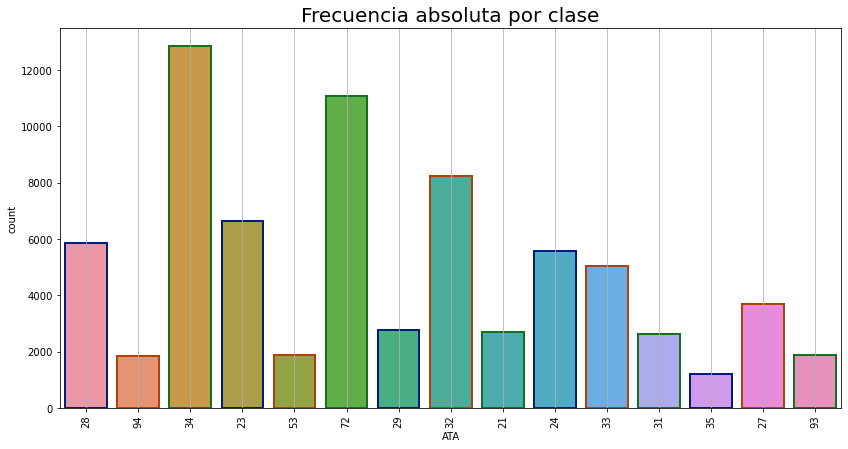

In [10]:
# Frecuencia absoluta de cada clase para validar si están balanceadas en cantidad de registros
fig = plt.figure(figsize=(14, 7))
sns.countplot(df['ATA'],linewidth=2,edgecolor=sns.color_palette("dark", 3), label = "Count")
plt.xticks(rotation=90)
plt.grid(axis='x')
plt.title('Frecuencia absoluta por clase', fontsize=20)
plt.show()

## MODELOS CLÁSICOS DE APRENDIZAJE SUPERVISADO

**En el aprendizaje supervisado, los algoritmos trabajan con datos “etiquetados” (labeled data), intentado encontrar una función que, dadas las variables de entrada (input data), les asigne la etiqueta de salida adecuada. El algoritmo se entrena con un “histórico” de datos y así “aprende” a asignar la etiqueta de salida adecuada a un nuevo valor, es decir, predice el valor de salida. (Simeone, 2018)**

**División del conjunto de entrenamiento y pruebas con semilla para asegurar datos fijos:**

- Conjunto de entrenamiento para entrenar el modelo
- Conjunto de prueba para medir cómo el modelo es capaz de generalizar (comportarse bien y predecir correctamente sobre datos nuevos)

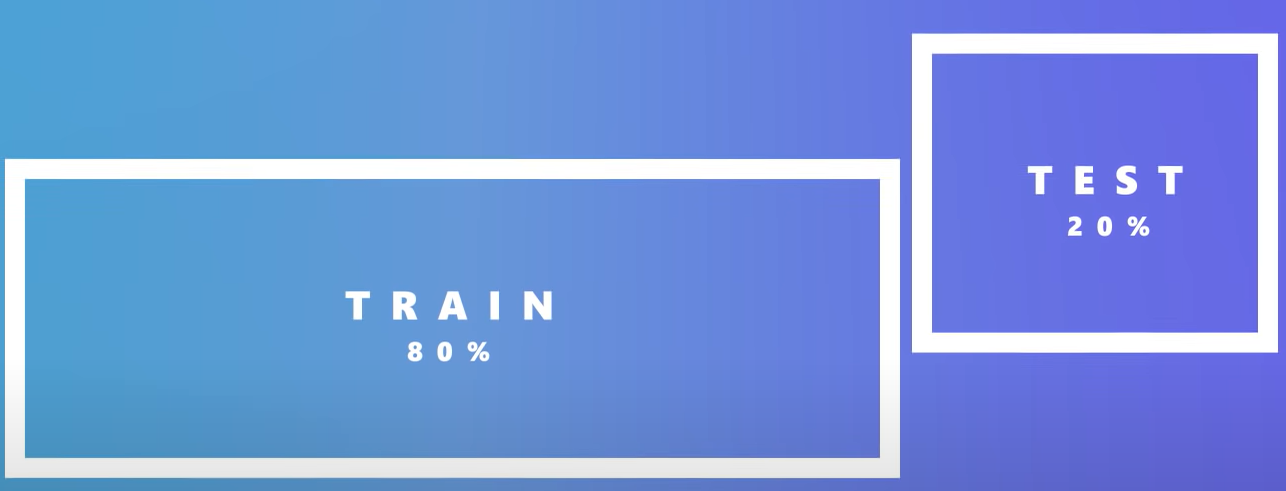

In [11]:
x_train, x_test, y_train, y_test = train_test_split(df['Reporte_Procesado'], df['ATA'],
                                                                        test_size=0.2, random_state=42)

**Creación de CountVectorizer para contar el número de veces que aparece una palabra (frecuencia) en cada uno de los reportes, el resultado es una matriz, por ejemplo:**

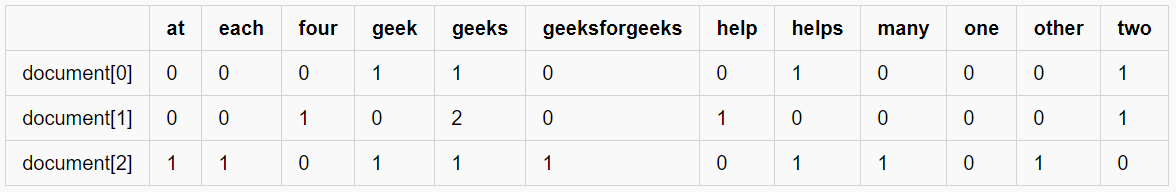

**Posterior se aplica TF-IDF (Frecuencia de Término - Frecuencia Inversa de Documento) a la matriz resultante del conteo de palabras y así calcular el peso e importancia de cada palabra, es decir, una palabra que se repita/use la mayor cantidad de veces en los textos del reporte, será la que menor puntuación tenga.**

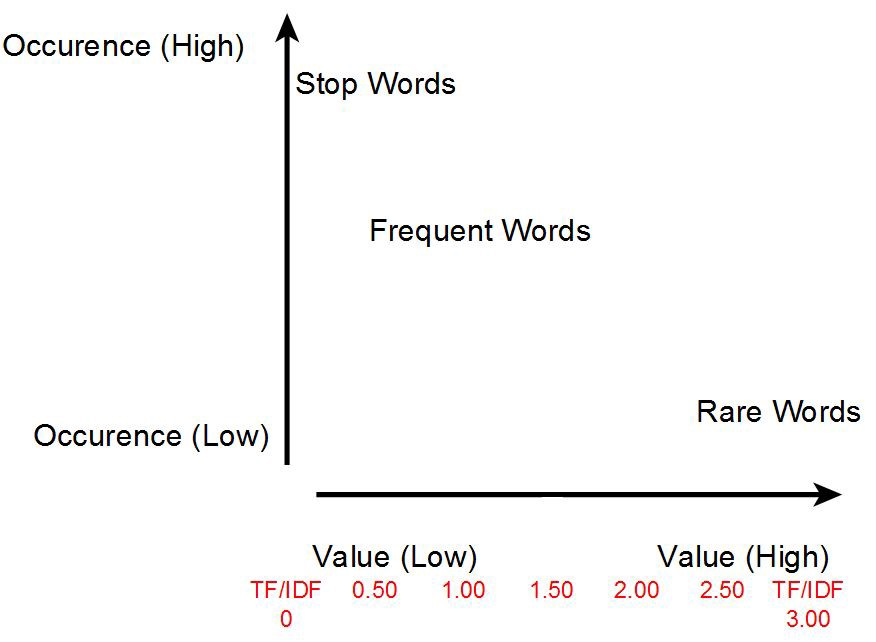

In [12]:
count_vect = CountVectorizer()
x_train_counts = count_vect.fit_transform(x_train)
tfidf_transformer = TfidfTransformer()
x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)

**Definición de los algoritmos de clasificación supervisados mediante un diccionario**

In [13]:
clfs = {
    'Complement NB': ComplementNB(),
    'Multinomial NB': MultinomialNB(),
    'SVM Linear': SVC(kernel='linear'),
    'SVM RBF': SVC(kernel='rbf'),
    'SVM Sigmoid': SVC(kernel='sigmoid'),
    'AdaBoost': AdaBoostClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Logistic Regression': LogisticRegression()
}

**Creación, entrenamiento, predicción y métricas de cada modelo**

In [14]:
listaYPredTrain, listaYPred, tiempo = [], [], []
Modelos, reporte, reporteTrain = [], [], []
for clf_name in clfs:
    Modelos.append(clf_name)
    print(clf_name)
    clf = clfs[clf_name]
    inicio = datetime.now()
    clf.fit(x_train_tfidf, y_train)
    fin = datetime.now()
    tiempo.append(round((fin - inicio).total_seconds(), 2))
    y_pred = clf.predict(count_vect.transform(x_test))
    listaYPred.append(y_pred)
    reporte.append(classification_report(y_test, y_pred, output_dict=True))
    y_predTrain=clf.predict(count_vect.transform(x_train))
    listaYPredTrain.append(y_predTrain)
    reporteTrain.append(classification_report(y_train, y_predTrain, output_dict=True))

Complement NB
Multinomial NB
SVM Linear
SVM RBF
SVM Sigmoid
AdaBoost
Decision Tree
Random Forest
Gradient Boosting
Logistic Regression


## Red Neuronal Artificial

**Una red neuronal artificial comprende un conjunto de unidades que se encuentran en una serie de capas que a su vez están conectadas a capas anexas, asemejando el tipo de conexiones que se generan en sistemas biológicos como las neuronas del cerebro. Estás redes son conjuntos interconectados de datos que trabajan en conjunto para darle solución a problemas específicos. (Graph Everywhere , s.f.)**

In [15]:
train_narrative, test_narrative, train_ATA, test_ATA = train_test_split(df['Reporte_Procesado'], df['ATA'],
                                                                        test_size=0.2, random_state=42)

**Tokenizer permite vectorizar el texto del reporte, convirtiendo cada reporte en una secuencia de números enteros (cada número entero es el el índice de una palabra en el vocabulario), como resultado se entrega una matriz con la longitud de los registros x la cantidad de palabras del vocabulario**

In [16]:
print("Número de palabras únicas (vocabulario):")
print(len(np.unique(np.hstack(df['Reporte_Procesado']))))

Número de palabras únicas (vocabulario):
72343


In [17]:
max_words = len(np.unique(np.hstack(df['Reporte_Procesado'])))
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

In [18]:
tokenize.fit_on_texts(train_narrative)
x_train = tokenize.texts_to_matrix(train_narrative)
x_test = tokenize.texts_to_matrix(test_narrative)

In [19]:
print('Matriz de entrenamiento:', x_train.shape)
print('Matriz de prueba:', x_test.shape)

Matriz de entrenamiento: (59140, 72343)
Matriz de prueba: (14786, 72343)


**LabelEncoder permite codificar etiquetas (label) de una clase en valores numéricos entre 0 y el número de clases menos 1, en este caso son 15 clases de sistema ATA**

In [20]:
encoder = LabelEncoder()
encoder.fit(train_ATA)
y_train = encoder.transform(train_ATA)
y_test = encoder.transform(test_ATA)

**To_categorical convierte las etiquetas enteras a codificación one hot, con el fin de mejorar el procesamiento de la máquina**

In [21]:
from keras.utils import np_utils
num_classes = np.max(y_train) + 1
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

### Arquitectura de la red

**La arquitectura de una red neuronal hace referencia a la topología que será implementada, en donde se incluye cantidad de capas, número de neuronas, funciones de activación, etc.:**

- Capa: es un conjunto de neuronas cuyas entradas provienen de una capa anterior (o de los datos de entrada en el caso de la primera capa) y cuyas salidas son la entrada de una capa posterior
- Neurona: conocida como unidad de proceso, reciben entradas y envían señales luego del procesamiento mediante una función de activación.
- Función de activación: devuelve una salida que será generada por la neurona dada una entrada o conjunto de entradas. Cada una de las capas que conforman la red neuronal tienen una función de activación que permitirá reconstruir o predecir. Además, se debe considerar que en la red neuronal se usará una función no lineal debido a que le permite al el modelo adaptarse para trabajar con la mayor cantidad de datos.

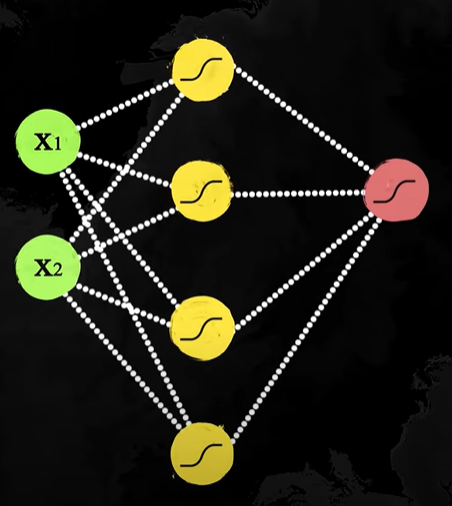

**Los siguiente parámetros fueron definidos inicialmente a prueba y error, enfocándo la búsqueda en la cantidad de épocas, posterior se realizó un gridSearch para obtener la mejor combinación de hiper-parámetros y de esta forma definir el esquema de arquitectura propuesto a continuación, antes recondando que en los modelos supervisados no hay una solución única sino un conjunto de soluciones en donde se busca encontrar la que mejor se adapte al problema:**

In [22]:
No_of_Units_in_dense_layers = 256
units = 2048
activation = 'relu'
kernel = 'uniform'
dropout_rate = 0.5
optimizer = 'Adam'
lr = 0.001
batch = 1024
epochs = 3
loss = 'categorical_crossentropy'

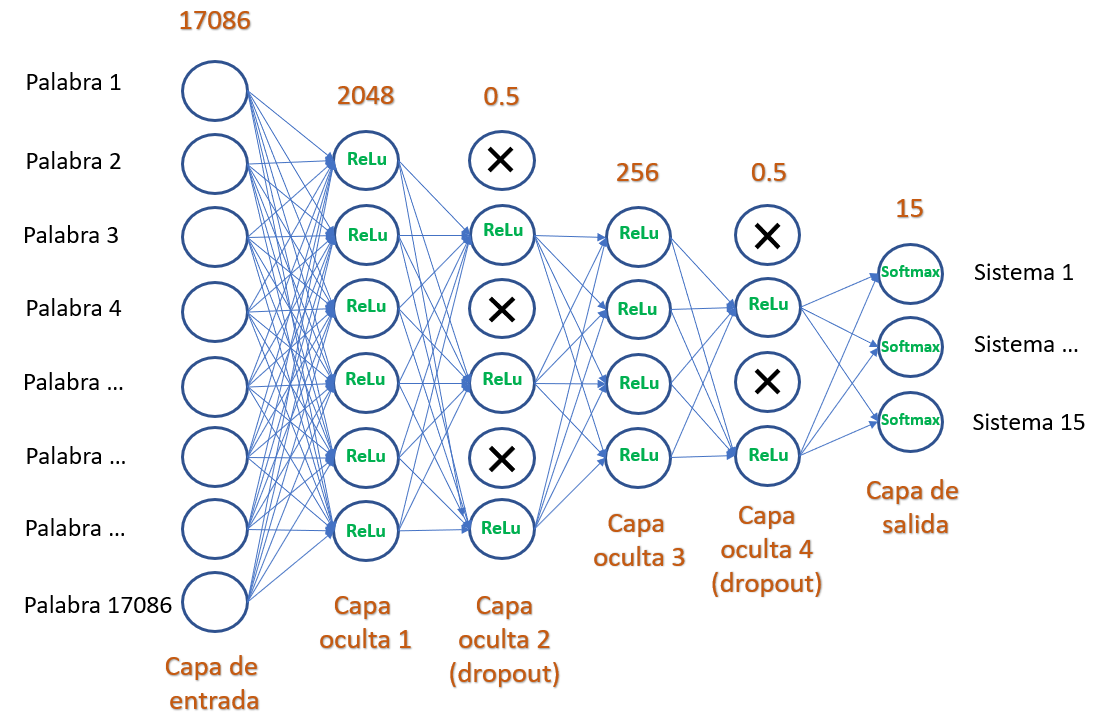

In [23]:
model = Sequential()
model.add(Dense(units=units, activation = activation,
            kernel_initializer = kernel, input_shape=(max_words,)))
model.add(Dropout(dropout_rate))
model.add(Dense(units=No_of_Units_in_dense_layers,activation=activation))
model.add(Dropout(dropout_rate))

model.add(Dense(num_classes, activation='softmax'))  

if optimizer=="Adam":
    opt=tf.keras.optimizers.Adam(lr=lr)

model.compile(loss=loss,optimizer=opt,
             metrics=['accuracy', 'Precision', 'Recall', get_f1])

**Entrenamiento del modelo sobre el 80 % de los datos, tomando 20 % de ellos para realizar validación, 5 épocas o iteraciones en donde todos los datos de entrenamiento pasan por cada neurona y así se puede generar aprendizaje, con el tamaño de batch se realizan lotes para ejecutar dentro de cada época.**

In [24]:
inicio = datetime.now()
history = model.fit(x_train, y_train,
                    batch_size=batch,
                    epochs=epochs,
                    validation_split=0.2)
fin = datetime.now()
tiempo.append(round((fin - inicio).total_seconds(), 2))

Epoch 1/3
47/47 [==============================] - 27s 461ms/step - loss: 1.3694 - accuracy: 0.6271 - precision: 0.8711 - recall: 0.4088 - get_f1: 0.5039 - val_loss: 0.6627 - val_accuracy: 0.8290 - val_precision: 0.8871 - val_recall: 0.7521 - val_get_f1: 0.8145
Epoch 2/3
47/47 [==============================] - 17s 357ms/step - loss: 0.5528 - accuracy: 0.8525 - precision: 0.9026 - recall: 0.7917 - get_f1: 0.8440 - val_loss: 0.5525 - val_accuracy: 0.8523 - val_precision: 0.8918 - val_recall: 0.8131 - val_get_f1: 0.8513
Epoch 3/3
47/47 [==============================] - 17s 352ms/step - loss: 0.3712 - accuracy: 0.8968 - precision: 0.9246 - recall: 0.8616 - get_f1: 0.8919 - val_loss: 0.5350 - val_accuracy: 0.8542 - val_precision: 0.8878 - val_recall: 0.8219 - val_get_f1: 0.8544


**Con la búsqueda y selección de hiper-parámetros se espera tener un buen modelo con capacidad de generalizar (datos nuevos) y evitar el sobreajuste:**

**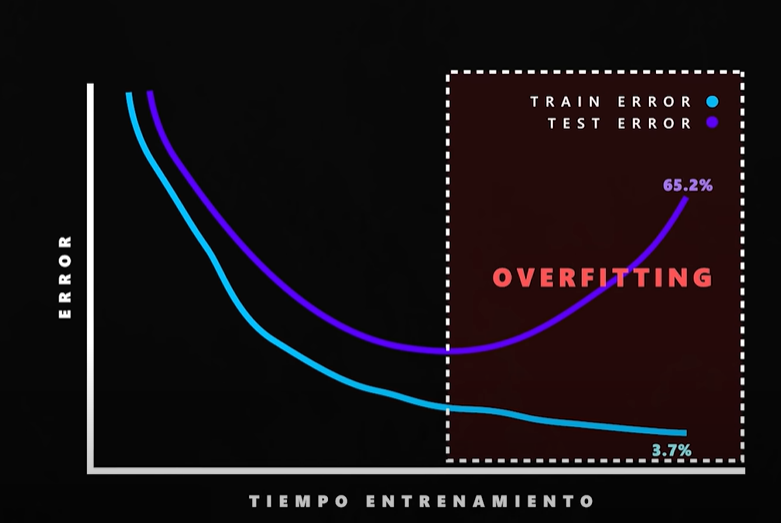**

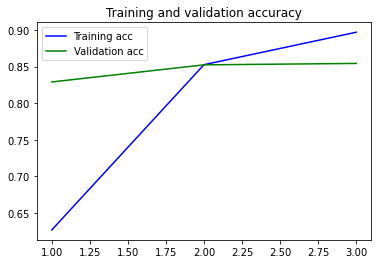

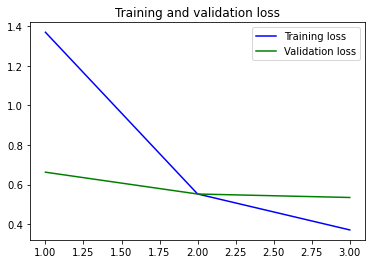

In [25]:
make_history_plot(history)

In [26]:
Modelos.append('Deep Learning')
y_predTrain=model.predict((x_train))
reporteTrain.append(classification_report(y_train.argmax(axis=1),y_predTrain.argmax(axis=1), output_dict=True))

In [27]:
y_predDL=model.predict((x_test))
reporte.append(classification_report(y_test.argmax(axis=1),y_predDL.argmax(axis=1), output_dict=True))

## Resultados

**Se obtiene cada uno de los valores de las métricas resultante de classification_report, para el problema de clasificación de sistemas ATA sobre los reportes de mantenimiento de las aeronaves y teniendo en cuenta que la cantidad de registros para cada clase está desbalanceada frente a las demás, se prestará mayor atención al resultado obtenido para el f1-score weighted, el cual evita el sesgo de las falsos positivos y negativos, así mismo, resume precission y recall, dando importancia a la clasificación de cada una de las clases de acuerdo al aporte sobre el conjunto.**

### En conjunto de entrenamiento

In [28]:
ListaResultadosTrain = []
for i in range(len(reporteTrain)):
    ListaResultadosTrain.append((Modelos[i], tiempo[i], reporteTrain[i].get('accuracy'), reporteTrain[i].get('macro avg').get('precision'), 
                        reporteTrain[i].get('macro avg').get('recall'), reporteTrain[i].get('macro avg').get('f1-score'), 
                        reporteTrain[i].get('weighted avg').get('precision'), reporteTrain[i].get('weighted avg').get('recall'), 
                       reporteTrain[i].get('weighted avg').get('f1-score')))
    
ResultadosTrain = pd.DataFrame(ListaResultadosTrain, columns = ['Modelo', 'Tiempo (seg)', 'Accuracy', 'Macro AVG/Precision', 
                                                      'Macro AVG/Recall', 'Macro AVG/f1-score', 'Weighted AVG/Precision', 
                                                     'Weighted AVG/Recall', 'Weighted AVG/f1-score'])

ResultadosTrain.to_excel('ResultadosTrain.xlsx')
ResultadosTrain

,Modelo,Tiempo (seg),Accuracy,Macro AVG/Precision,Macro AVG/Recall,Macro AVG/f1-score,Weighted AVG/Precision,Weighted AVG/Recall,Weighted AVG/f1-score
0,Complement NB,0.15,0.857643,0.871482,0.801269,0.817588,0.859124,0.857643,0.846760
1,Multinomial NB,0.14,0.789652,0.871112,0.648212,0.695443,0.815885,0.789652,0.766351
2,SVM Linear,182.13,0.872049,0.869808,0.852622,0.854092,0.880302,0.872049,0.870250
3,SVM RBF,423.11,0.155428,0.807091,0.105620,0.082932,0.762879,0.155428,0.100948
4,SVM Sigmoid,170.41,0.681924,0.660539,0.678404,0.649614,0.725285,0.681924,0.683505
5,AdaBoost,9.45,0.661836,0.701144,0.576733,0.601435,0.699777,0.661836,0.647132
6,Decision Tree,20.15,0.684207,0.681408,0.682335,0.672313,0.722339,0.684207,0.694559
7,Random Forest,170.19,0.970223,0.976548,0.960202,0.967444,0.971139,0.970223,0.970041
8,Gradient Boosting,362.80,0.786152,0.761998,0.766937,0.751540,0.802186,0.786152,0.787697
9,Logistic Regression,18.42,0.847058,0.839097,0.819514,0.822715,0.855269,0.847058,0.845833


### En conjunto de test

In [29]:
ListaResultados = []
for i in range(len(reporte)):
    ListaResultados.append((Modelos[i], reporte[i].get('accuracy'), reporte[i].get('macro avg').get('precision'), 
                        reporte[i].get('macro avg').get('recall'), reporte[i].get('macro avg').get('f1-score'), 
                        reporte[i].get('weighted avg').get('precision'), reporte[i].get('weighted avg').get('recall'), 
                       reporte[i].get('weighted avg').get('f1-score')))

Resultados = pd.DataFrame(ListaResultados, columns = ['Modelo' , 'Accuracy', 'Macro AVG/Precision', 
                                                      'Macro AVG/Recall', 'Macro AVG/f1-score', 'Weighted AVG/Precision', 
                                                     'Weighted AVG/Recall', 'Weighted AVG/f1-score'])

Resultados.to_excel('ResultadosTest.xlsx')
Resultados

,Modelo,Accuracy,Macro AVG/Precision,Macro AVG/Recall,Macro AVG/f1-score,Weighted AVG/Precision,Weighted AVG/Recall,Weighted AVG/f1-score
0,Complement NB,0.835452,0.842354,0.773803,0.788591,0.835009,0.835452,0.822081
1,Multinomial NB,0.765995,0.856120,0.611284,0.655187,0.799245,0.765995,0.737182
2,SVM Linear,0.815839,0.794399,0.788504,0.782575,0.822383,0.815839,0.811785
3,SVM RBF,0.143582,0.678722,0.094304,0.062562,0.640422,0.143582,0.083886
4,SVM Sigmoid,0.695658,0.676527,0.693764,0.665370,0.733790,0.695658,0.694601
5,AdaBoost,0.662113,0.698058,0.575034,0.600614,0.698476,0.662113,0.647110
6,Decision Tree,0.592114,0.582095,0.569796,0.570959,0.623859,0.592114,0.603008
7,Random Forest,0.816921,0.832939,0.749506,0.772193,0.816747,0.816921,0.804873
8,Gradient Boosting,0.764439,0.736743,0.735180,0.723843,0.779096,0.764439,0.764835
9,Logistic Regression,0.817733,0.803926,0.783358,0.786557,0.824113,0.817733,0.814960


In [30]:
ResultadosG = Resultados[['Modelo', 'Weighted AVG/Precision', 'Weighted AVG/Recall', 'Weighted AVG/f1-score']]
ResultadosGTrain = ResultadosTrain[['Modelo', 'Weighted AVG/Precision', 'Weighted AVG/Recall', 'Weighted AVG/f1-score']]
dfR = ResultadosG.melt('Modelo', var_name='Métrica',  value_name='Valor')
dfRTrain = ResultadosGTrain.melt('Modelo', var_name='Métrica',  value_name='Valor')

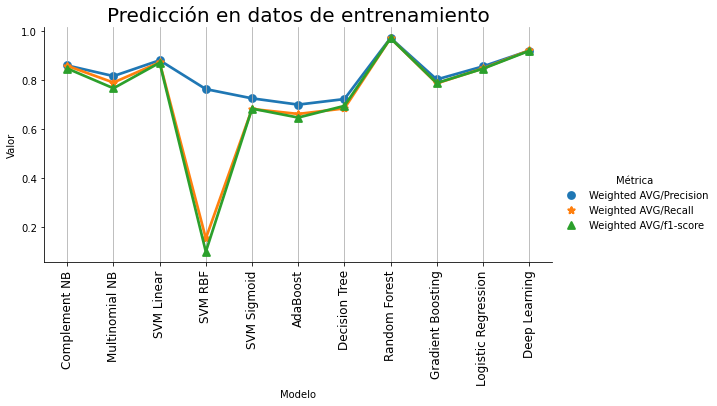

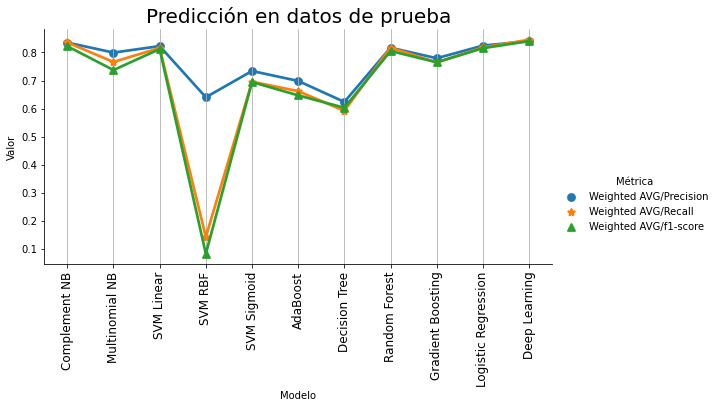

In [31]:
sns.factorplot(x="Modelo", y="Valor", hue='Métrica', data=dfRTrain, size=4, aspect=2, markers=['o', '*', '^'])
plt.xticks(rotation=90, size=12)
plt.grid(axis='x')
plt.title('Predicción en datos de entrenamiento', fontsize=20)
sns.factorplot(x="Modelo", y="Valor", hue='Métrica', data=dfR, size=4, aspect=2, markers=['o', '*', '^'])
plt.xticks(rotation=90, size=12)
plt.grid(axis='x')
plt.title('Predicción en datos de prueba', fontsize=20)
plt.show()

**Los modelos de clasificación SVM RBF, AdaBoost, Decision Tree y Gradient Boosting son los que menor resultado obtuvieron en las métricas, así como el modelo basado en Random Forest presenta un buen resultado sobre los datos de prueba pero presentan sobreajuste, lo cual puede suponer un problema de generalización al momento de predecir sobre nuevos datos.**

**Los modelos ComplementNB, Logistic Regression, máquina de soporte lineal y la red neuronal presentan buenas métricas en los conjuntos de entrenamiento y prueba sin sobreajuste.**

### Matriz de confusión

**El desempeño de los cuatro mejores modelos de clasificación se visualiza mediante matrices de confusión para cada uno, con el fin de representar las predicciones para cada clase versus la clasificación real.**

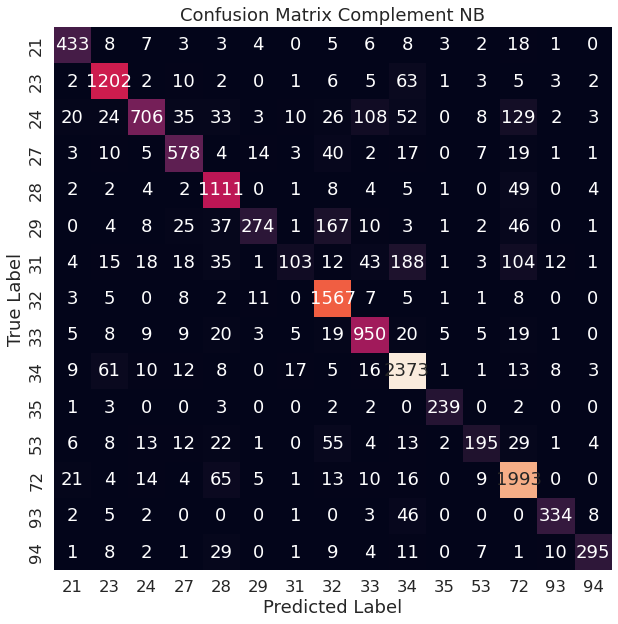

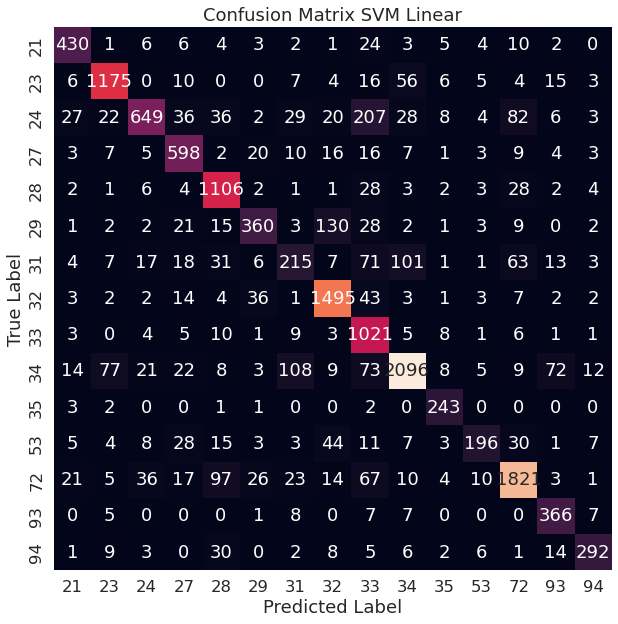

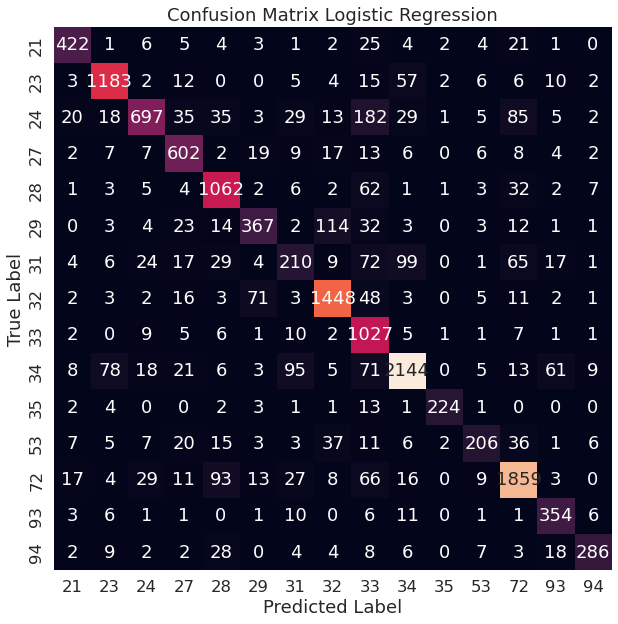

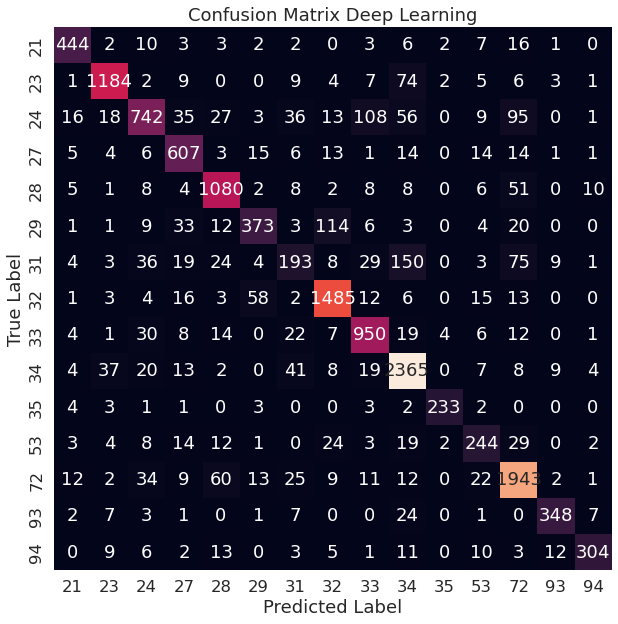

In [32]:
indices = [0, 2, 9, 10]
y_true = test_ATA[0:]
etiquetas = test_ATA.unique()
etiquetas = sorted(etiquetas.tolist())
y_true = y_true.to_list()
for ind in indices:
    if ind != 10:
        plt.figure(figsize=(10,10))
        confusion_matrix_c(y_true, listaYPred[ind], Modelos[ind])
    elif ind == 10:
        y_pred = y_predDL.argmax(axis=1)
        y_pred = encoder.inverse_transform(y_pred)
        plt.figure(figsize=(10,10))
        confusion_matrix_c(y_true, y_pred, Modelos[ind])